# Protein Classificator

## Importing required packages

In [11]:
!pip3.7 install biopython

In [12]:
 !pip3.7 install fair-esm

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy

from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

Command to run to open data files in Google Colab environment.

In [14]:
!unzip data.zip

Archive:  data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace data/proteomes/UP000001974_273057.fasta? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Configuration of temperature labels and input files

In [15]:
temperature_labels_full = [37, 80]

files = ['data/proteomes/UP000000625_83333.fasta', 'data/proteomes/UP000001974_273057.fasta']

## Splitting the dataset for training, validation and testing

The proportions for splitting were chosen to be 70%, 15% and 15% for training, validation and testing respectively.

In [16]:
# Initialisation of the dataset container
data = {
    'train': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/training_',
        'CSV_prefix': 'data/CSV/training_',
    },
    'validate': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/validation_',
        'CSV_prefix': 'data/CSV/validation_'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/testing_',
        'CSV_prefix': 'data/CSV/testing_'
    }
}

# Removing duplicate sequences in the dataset
seen = set()

for i in range(len(temperature_labels_full)):
    records = [] 
    # Parsing sequences (X dataset) from one dataset 
    for record in SeqIO.parse(files[i], "fasta"):
        if record.seq not in seen:
            seen.add(record.seq)
            records.append(record)

    # Creating Y dataset from temperature labels 
    temperature_labels = [temperature_labels_full[i]] * len(records)

    # Spliting the dataset to 70% (training) and 30% (trying)
    X_train, X_try, Y_train, Y_try = train_test_split(records, temperature_labels, test_size=0.3, shuffle=True, random_state=1)

    # Splitting 30% from the initial set in half for calidation and testing
    X_validate, X_test, Y_validate, Y_test = train_test_split(X_try, Y_try, test_size=0.5, shuffle=True, random_state=1)

    data['train']['X'] = data['train']['X'] + X_train
    data['train']['Y'] = data['train']['Y'] + Y_train
    data['validate']['X'] = data['validate']['X'] + X_validate
    data['validate']['Y'] = data['validate']['Y'] + Y_validate
    data['test']['X'] = data['test']['X'] + X_test
    data['test']['Y'] = data['test']['Y'] + Y_test

# Shuffling the datasets
for element in data.keys():
    data[element]['X'], data[element]['Y'] = shuffle(data[element]['X'], data[element]['Y'], random_state=1)



## Checking the success of parsing

In [ ]:
print(len(seen))
print(len(data['train']['X']))
print(len(data['validate']['X']))
print(len(data['test']['X']))

7288
5101
1093
1094


## Checking the maximum length

In [ ]:
max_length = 0
max_length_seq = None

for element in data.keys():
    for i in range(len(data[element]['X'])):
        if(len(data[element]['X'][i].seq) > max_length):
            max_length = len(data[element]['X'][i].seq)
            max_length_seq = data[element]['X'][i]

print(max_length)
print(max_length_seq)

2358
ID: sp|P76347|YEEJ_ECOLI
Name: sp|P76347|YEEJ_ECOLI
Description: sp|P76347|YEEJ_ECOLI Uncharacterized protein YeeJ OS=Escherichia coli (strain K12) OX=83333 GN=yeeJ PE=3 SV=3
Number of features: 0
Seq('MATKKRSGEEINDRQILCGMGIKLRRLTAGICLITQLAFPMAAAAQGVVNAATQ...KNL')


## Creating files 

`[training|validation|testing]_sequences.fasta`

In [ ]:
# Creating data/FASTA/*_sequences.fasta files

for element in data.keys():
    file_name = data[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for record in data[element]['X']:
        file_handle.write('>'+record.name.split('|')[1])
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

  `[training|validation|testing]_temperature_annotations.csv`

In [ ]:
# Creating data/*_temperature_annotations.csv files

for element in data.keys():
    file_name = data[element]['CSV_prefix']+'temperature_annotations.csv'
    file_handle = open(file_name, 'w')
    file_handle.write('identifier,label'+"\n")
    for i in range(len(data[element]['X'])):
        file_handle.write(data[element]['X'][i].name.split('|')[1]+','+str(data[element]['Y'][i]))
        file_handle.write("\n")
    file_handle.close()

## Filtering sequences from initial FASTA files 

Since the visualisation is not allowed without embedding for each FASTA sequence, it was required to filter all sequences and keep only those that have their embeddings.

In [17]:
data_filtered = {
    'train': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_training_',
        'CSV_prefix': 'data/CSV/filtered_training_',
        'embedding_list': './data/EMB_ESM1b/training_embeddings.lst',
        'embeddings': ''
    },
    'validate': {
        'X': [],
        'Y': [],
        'FASTA_prefix': 'data/FASTA/filtered_validation_',
        'CSV_prefix': 'data/CSV/filtered_validation_',
        'embedding_list': './data/EMB_ESM1b/validation_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/validation_sequences'
    },
    'test': {
        'X' : [],
        'Y' : [],
        'FASTA_prefix': 'data/FASTA/filtered_testing_',
        'CSV_prefix': 'data/CSV/filtered_testing_',
        'embedding_list': './data/EMB_ESM1b/testing_embeddings.lst',
        'embeddings': '/content/drive/MyDrive/testing_sequences'
    }
}

for element in data.keys():
    emb_list_handle = open(data_filtered[element]['embedding_list'], 'r')
    emb_list = emb_list_handle.readlines()
    emb_list_handle.close()
    emb_set = set()
    for j in range(len(emb_list)):
        emb_set.add(emb_list[j].split('.')[0])
    for i in range(len(data[element]['X'])):
        if(data[element]['X'][i].id.split('|')[1] in emb_set):
            data_filtered[element]['X'].append(data[element]['X'][i])
            data_filtered[element]['Y'].append(data[element]['Y'][i])


Testing, whether the filtration was successful.

In [20]:
print(len(data_filtered['train']['X']))
print(len(data_filtered['validate']['X']))
print(len(data_filtered['test']['X']))

5056
1079
1080


## Creating filtered FASTA files

In [23]:
# Creating data/FASTA/filtered_*_sequences.fasta files

for element in data_filtered.keys():
    file_name = data_filtered[element]['FASTA_prefix']+'sequences.fasta'
    file_handle = open(file_name, 'w')
    for i in range(len(data_filtered[element]['X'])):
    #for i in range(5):
        #file_handle.write('>'+record.name.split('|')[1])
        file_handle.write('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        #print('>'+data_filtered[element]['X'][i].name.split('|')[1]+'|'+str(data_filtered[element]['Y'][i]))
        file_handle.write("\n")
        file_handle.write(str(record.seq))
        file_handle.write("\n")
    file_handle.close()

## Visualisation of embeddings

In [18]:
!pip3.7 install pymde

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import esm
import torch

#FASTA_PATH = ["data/FASTA/filtered_validation_sequences.fasta", "data/FASTA/filtered_testing_sequences.fasta"] 
#EMB_PATH = ["/content/drive/MyDrive/validation_sequences", "/content/drive/MyDrive/testing_sequences"] # Path to directory of embeddings for FASTA files
EMB_LAYER = 33

Ys = []
Xs = []

keys = ['validate', 'test']

for key in keys:
    FASTA_PATH = data_filtered[key]['FASTA_prefix']+'sequences.fasta'
    EMB_PATH = data_filtered[key]['embeddings']
    for header, _seq in esm.data.read_fasta(FASTA_PATH):
        temperature_label = header.split('|')[-1]
        Ys.append(int(temperature_label))
        file_name = header.split('|')[0][1:]
        fn = f'{EMB_PATH}/{file_name}.pt'
        embs = torch.load(fn)
        Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()


"\nfor header, _seq in esm.data.read_fasta(FASTA_PATH):\n    temperature_label = header.split('|')[-1]\n    Ys.append(int(temperature_label))\n    file_name = header.split('|')[0][1:]\n    fn = f'{EMB_PATH}/{file_name}.pt'\n    embs = torch.load(fn)\n    Xs.append(embs['mean_representations'][EMB_LAYER])\n\n\nXs = torch.stack(Xs, dim=0).numpy()\n"

In [25]:
print(len(Ys))
print(Xs.shape)

2159
(2159, 1280)


In [26]:
pca = PCA(60)
Xs_train_pca = pca.fit_transform(Xs)

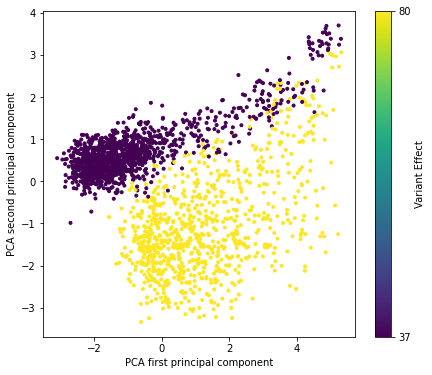

In [27]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=Ys, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect', ticks=numpy.linspace(37, 80, 2))
plt.savefig('validation_and_testing_sequences_visualisation_matplotlib.png')

In [28]:
import pymde

Xs_torch = torch.from_numpy(Xs)

embedding = pymde.preserve_neighbors(Xs_torch).embed(verbose=True)

Nov 11 11:47:09 AM: Fitting a centered embedding into R^2, for a graph with 2159 items and 34445 edges.
Nov 11 11:47:09 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Nov 11 11:47:09 AM: iteration 000 | distortion 0.893151 | residual norm 0.895467 | step length 0.114674 | percent change 0.156269
Nov 11 11:47:10 AM: iteration 030 | distortion 0.256327 | residual norm 0.00311649 | step length 1 | percent change 2.85006
Nov 11 11:47:10 AM: iteration 060 | distortion 0.227095 | residual norm 0.00121586 | step length 1 | percent change 0.938188
Nov 11 11:47:10 AM: iteration 090 | distortion 0.222989 | residual norm 0.000635123 | step length 1 | percent change 1.03788
Nov 11 11:47:11 AM: iteration 120 | distortion 0.221719 | residual norm 0.00043789 | step length 1 | percent change 0.0805424
Nov 11 11:47:11 AM: iteration 150 | distortion 0.221478 | residual norm 0.000280506 | step length 1 | percent change 0.447475
Nov 11 11:47:11 AM: iteration 180 | distortion 0.22

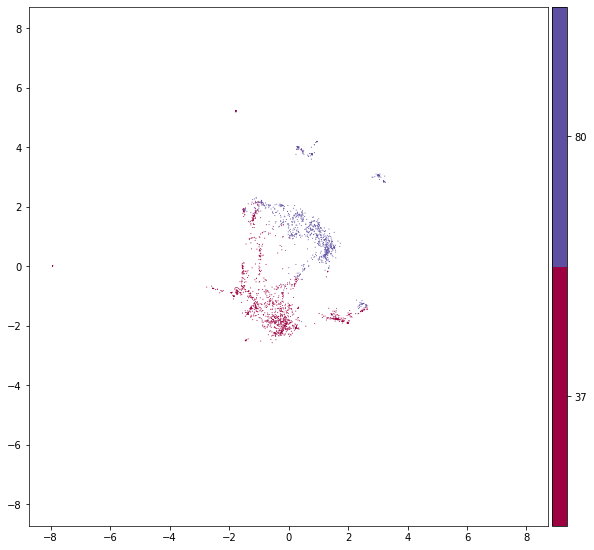

In [30]:
pymde.plot(embedding, color_by=Ys, savepath='validation_and_testing_sequences_visualisation_PyMDE.png')

## Creating a simple feed-forward neural network with Keras.

`LabelBinarizer` - package that is used to one-hot encode integer labels as vector labels.

`classification_report` - function that gives a nicely formatted report to display the total accuracy of the model. Also it might show breakdown on the classification accuracy for wach digit.

`Sequential` - class that indicates that the network will be feed-forward and layers will be added to the class sequentially (one on top of the other).

`Dense` - class that is the implementation of the fully connected layers.

Stochastic gradient descent (`SGD`) - required for the network to actually learn - it optimizes the parameters of the network.

`mnist` - helper function that provides access to full MNIST dataset.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import argparse

### Loading dataset

In [ ]:
print("[INFO] accessing datasets...")
#trainX = data['train']['X']
#trainY = data['train']['Y']
#testX = data['validation']['X']
#testY = data['validation']['Y']
((trainX, trainY), (testX, testY)) = mnist.load_data()

# Reshape
trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] accessing datasets...


### Encoding the labels 

Firstly, integer labels are transformed into vector labels.

In [ ]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

### Defining network architecture

`Sequential()` - instantiates the feedforward architecture.

`model.add(Dense(...))` - defines the fully connected layer in the network. 

1. The dimension is equal to the number of each MNIST data points. This layer learns 256 weights and applies sigmoid activation function.

2. The layer learns 128 weights. Activation function is also sigmoid.

3. The layer that learns 10 weights. The activation function is softmax. This activation function obtains normalized class probabilities for each prediction.



In [ ]:
# define the ?-?-?-? architecture using Keras
model = Sequential()
model.add(Dense(256, input_shape=(784,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

### Training the network

1. Initializing the SGD optimizer with a learning rate of 0.01 (common notation 1e-2)
2. categorical_crossentropy loss function is used as the loss metric.
3. Calling `model.fit()` method to start the training of the network. This method returns a dictionary (`H`), which will be later used for accuracy plotting.


In [ ]:
# train the model using SGD
print("[INFO] training network...")
sgd = SGD(0.01)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=100, batch_size=128)

### Evaluating the accuracy of the model

1. `model.predict()` method returns all of the class label probabilities for every data point in testX. In other words, `predictions` NumPy array has the shape `(X, 10)`, where `X` is the total number of data points in the testing set and `10` stands for the number of possible class labels.
2. `argmax(axis=1)` function will give the index of the class label that has the largest probability (final output classification).

The final output is tabulated.

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1),target_names=[str(x) for x in lb.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.91      0.90      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.90      0.87      0.88       892
           6       0.93      0.95      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.89      0.90      0.89       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



### Visualization of the results

Plotting the training loss, training accuracy, validation loss, and validation accuracy.

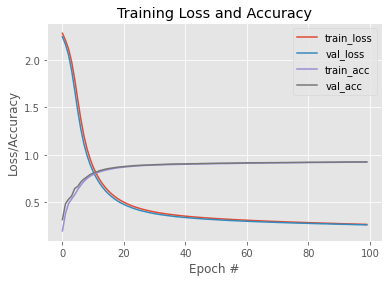

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()